In [15]:
#Import required packages
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.autograd import grad
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

In [16]:
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

#Custom loss function
def loss_fun(pred, alpha=1E7):
    """Computes scalarized loss including genetic constraint and product production"""
    j1 = pred[-1][-2]
    j2 = pred[-1][-1]
    loss = j1 + alpha*j2
    return loss

class DualControl(torch.nn.Module):
    def __init__(self):
        super(DualControl, self).__init__()
        #Initialize constants, taken from Verma et al paper.
        self.Vin = 1.
        self.e0 = 0.0467
        self.lam = 1.93E-4 #1/s
        #Assume equal kinetics for all three enzymes
        self.kc = 12
        self.km = 10 #1/s

        self.W = torch.nn.Parameter(torch.tensor([[2,2],[1,1], [1E-7, 1E-7]]), requires_grad=True)
        

    def forward(self, t, y):
        '''Computes derivatives of system of differential equations'''
        dx0 = self.Vin - self.lam*y[0] - self.e0*nonlinearity(y[0], self.kc, self.km) - self.lam*y[1]
        dx1 = y[2]*nonlinearity(y[0], self.kc, self.km) - y[3]*nonlinearity(y[1], self.kc, self.km) - self.lam*y[1]
        de1 = repression(y[1], self.W[2][0], self.W[1][0], self.W[0][0]) - self.lam*y[2]
        de2 = activation(y[1], self.W[2][1], self.W[1][1], self.W[0][1]) - self.lam*y[3]
        j1 = (self.Vin -  y[3]*nonlinearity(y[1], self.kc, self.km))**2
        j2 = repression(y[1], self.W[2][0], self.W[1][0], self.W[0][0]) + activation(y[1], self.W[2][1], self.W[1][1], self.W[0][1])
        return torch.stack([dx0, dx1, de1, de2, j1, j2])

class ODEFun(torch.nn.Module):
    def __init__(self):
        super(ODEFun, self).__init__()
        self.W = torch.nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=True)
        
    def forward(self, t, y):
        S, I = y
        ds = -self.W[0]*S*I
        di = self.W[1]*S*I - I
        return torch.stack([ds, di])


In [24]:
func = DualControl()
learning_rate = 1
num_iters = 100
optimizer = optim.Adam(func.parameters(), amsgrad=False, lr=learning_rate)
adjoint = False
alpha = 1E7
solver = 'dopri8'

np.random.seed(2021)
# torch.manual_seed(2021)
plt.close('all')

#Establish initial conditions
t = torch.linspace(0, 5E4, 100) 
y0 = torch.tensor([2290., 0., 0., 0., 0., 0.]) 
# y0 = torch.tensor([0.99, 0.01])

In [25]:
pred = odeint(func, y0, t, method=solver)

Text(0, 0.5, 'Concentrations')

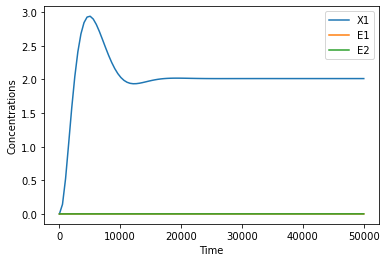

In [26]:

sol1 = pred.detach().numpy()
#plt.plot(t, sol1[:, 0], label='X0')
plt.plot(t, sol1[:, 1], label='X1')
plt.plot(t, sol1[:, 2], label='E1')
plt.plot(t, sol1[:, 3], label='E2')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentrations')

In [27]:
loss = loss_fun(pred, alpha = alpha)
print(func.W.grad)
loss.backward()
print(func.W.grad)
optimizer.step()

None
tensor([[-5.2252e+03,  5.2363e+03],
        [ 1.5180e+04, -1.5211e+04],
        [ 1.0527e+11,  3.9387e+11]])


In [8]:
#Plot solution and compare to traditional ODE solver
def dual_control(x, t, n1, n2, theta1, theta2, k1, k2):
    x0, x1, e1, e2, j1, j2 = x
    dx0dt = Vin - lam*x0 - e0*nonlinearity(x0, kc, km) - e1*nonlinearity(x0, kc, km) 
    dx1dt = e1*nonlinearity(x0, kc, km) - e2*nonlinearity(x1, kc, km) - lam*x1
    de1dt = repression(x1, k1, theta1, n1) - lam*e1
    de2dt = activation(x1, k2, theta2, n2) - lam*e2
    j1 = (Vin -  e2*nonlinearity(x1, kc, km))**2
    j2 = repression(x1, k1, theta1, n1) + activation(x1, k2, theta2, n2)
    return [dx0dt, dx1dt, de1dt, de2dt, j1, j2]  
from scipy.integrate import odeint as ode


Vin = func.Vin
e0 = func.e0 
lam = func.lam
kc = func.kc
km = func.km

n1 = 2
n2 = 2
theta1 = 1
theta2 = theta1
k1 = 1E-7
k2 = 1E-7
sol = ode(dual_control, y0, t, args=(n1, n2, theta1, theta2, k1, k2))

Text(0, 0.5, 'Concentrations')

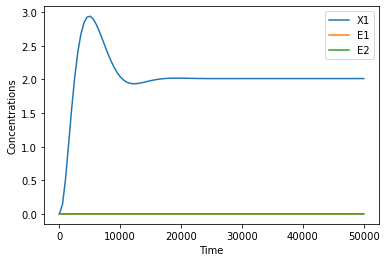

In [9]:
#plt.plot(t, sol[:, 0], label='X0')
plt.plot(t, sol[:, 1], label='X1')
plt.plot(t, sol[:, 2], label='E1')
plt.plot(t, sol[:, 3], label='E2')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Concentrations')

itr loss theta_0 theta_1
0 0.4809 0.1 0.1
10 0.4712 0.6093 0.7778
20 0.4438 1.006 1.3182
30 0.3735 1.367 1.7792
40 0.3035 1.6361 2.0912
50 0.2592 1.8355 2.3033
60 0.2296 1.9957 2.4659
70 0.2078 2.1314 2.6012
80 0.1907 2.2505 2.7194
90 0.1767 2.3576 2.8259
100 0.1649 2.4556 2.9242
110 0.1546 2.5464 3.0162
120 0.1456 2.6314 3.1034
130 0.1375 2.7116 3.1869
140 0.1301 2.7877 3.2673
150 0.1234 2.8603 3.3452
160 0.1172 2.9299 3.4211
170 0.1115 2.9967 3.4952
180 0.1062 3.0612 3.568
190 0.1011 3.1235 3.6396
200 0.0964 3.1838 3.7101
210 0.092 3.2424 3.7798
220 0.0878 3.2992 3.8488
230 0.0838 3.3545 3.9171
240 0.08 3.4083 3.9849
250 0.0764 3.4607 4.0523
260 0.073 3.5118 4.1192
270 0.0697 3.5617 4.1859
280 0.0665 3.6103 4.2522
290 0.0635 3.6577 4.3182
300 0.0606 3.704 4.384
310 0.0578 3.7492 4.4496
320 0.0552 3.7933 4.5151
330 0.0526 3.8363 4.5803
340 0.0502 3.8783 4.6454
350 0.0478 3.9192 4.7103
360 0.0455 3.9591 4.7751
370 0.0433 3.998 4.8397
380 0.0412 4.0359 4.9042
390 0.0392 4.0728 4.9685
40

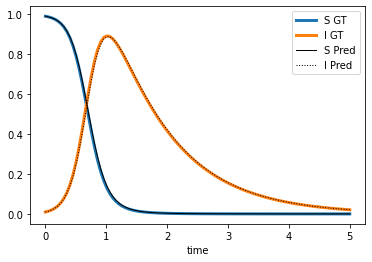

In [66]:
#Oisin's example
import matplotlib.pyplot as plt
import numpy as np
import torch 
#from scipy.integrate import odeint
from torch.autograd import grad

from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

np.random.seed(2021)
torch.manual_seed(2021)
plt.close('all')



def loss_fun(gt, pred):
    return ((gt-pred)**2).mean()
    

class ODEFun(torch.nn.Module):
    def __init__(self):
        super(ODEFun, self).__init__()
        self.theta = torch.nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=True)
        
    def forward(self, t, y):
        S, I = y
        ds = -self.theta[0]*S*I
        di = self.theta[1]*S*I - I
        return torch.stack([ds, di])

def gt_fun(t, y):
    theta_0 = 5.5
    theta_1 = 8.0
    S, I = y
    ds = -theta_0*S*I
    di = theta_1*S*I - I
    return torch.stack([ds, di])
        
true_y0 = torch.tensor([0.99, 0.01])
t = torch.linspace(0, 5, 100) 


# gt
with torch.no_grad():
    true_y = odeint(gt_fun, true_y0, t, method='dopri5')
    true_y_noise = true_y + torch.randn(true_y.shape)*0.02
    #true_y_adj = odeint_adjoint(gt_fun, true_y0, t, method='dopri5')


func = ODEFun()
lr = 0.01
num_iters = 1000
optimizer = torch.optim.RMSprop(func.parameters(), lr=lr)
grads = []
print('itr loss theta_0 theta_1')
for ii in range(num_iters): 
    
    optimizer.zero_grad()
    
    pred = odeint(func, true_y0, t, method='dopri5')
    #pred = odeint_adjoint(func, true_y0, t, method='dopri5')
    loss = loss_fun(true_y_noise, pred)
    loss.backward()
    optimizer.step()
    
    if ii % 10 == 0:
        grads.append(func.theta.grad.clone().detach().numpy())
        print(ii, round(loss.item(), 4), round(func.theta[0].item(), 4), round(func.theta[1].item(), 4))
        

# Note: here the GT values are hardcoded - fix
print('\n')
print('GT  : theta_0: {:2.2}, theta_1: {:2.2}'.format(5.5, 8.0))
print('Pred: theta_0: {:2.2}, theta_1: {:2.2}'.format(round(func.theta[0].item(), 4), round(func.theta[1].item(), 4)))



plt.figure(1)
with torch.no_grad():
    plt.plot(t, true_y[:,0], 'C0', lw=3, label='S GT')
    plt.plot(t, true_y[:,1], 'C1', lw=3, label='I GT')
    plt.plot(t, pred[:,0], 'k', lw=1, label='S Pred')
    plt.plot(t, pred[:,1], ':k', lw=1, label='I Pred')
plt.legend()
plt.xlabel('time')
plt.show()

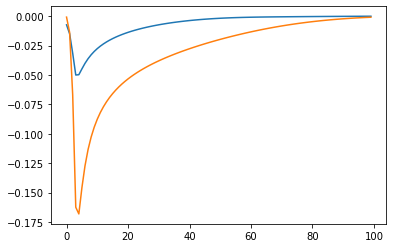

In [67]:
plt.plot(np.array(grads)[:, 0])
plt.plot(np.array(grads)[:, 1])

In [54]:
np.array(grads)

/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_41099/1029307458.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.array(grads)
/var/folders/fz/1kd077v55dz4fd956zt4jrc40000gn/T/ipykernel_41099/1029307458.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(grads)


array([tensor([-0.0074, -0.0008]), tensor([-0.0149, -0.0138]),
       tensor([-0.0315, -0.0669]), tensor([-0.0500, -0.1625]),
       tensor([-0.0498, -0.1681]), tensor([-0.0448, -0.1458]),
       tensor([-0.0401, -0.1273]), tensor([-0.0362, -0.1134]),
       tensor([-0.0328, -0.1028]), tensor([-0.0300, -0.0944])],
      dtype=object)